In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [71]:
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv

teams = teams.get_teams()
#print(teams)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# List of current NBA team IDs
current_teams = [1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]
#print('base_data = ',data.columns)

#adding PER
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])


#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day

#**Convert all non-numeric values in a column
# Encode non-numeric values in the 'TEAM_ID' column as categorical variables
data_encoded = pd.get_dummies(data, columns=['TEAM_ID'], prefix='TEAM')

#**Drop Missing values
# Drop rows with missing values
data_encoded = data_encoded.dropna()

# Filter the data to include only selected columns
data_encoded_selected = data_encoded.iloc[:, :30]

# Get Unique Teams prior to modeling <takes out all the other games for these teams, find why Mavs are showing up twice in final set>
#data_encoded_unique = data_encoded_selected.drop_duplicates(subset='TEAM_NAME').copy()

# Check the updated column names in the DataFrame
print('encoded_data = ',data_encoded_selected.columns)
#print(data_encoded_selected)

# Filter the data for the 2022-2023 NBA season
start_date = pd.to_datetime('2022-10-01')
end_date = pd.to_datetime('2023-06-30')
season_data = data_encoded_selected[(data_encoded_selected['GAME_DATE'] >= start_date) & (data_encoded_selected['GAME_DATE'] <= end_date)].copy()

# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
print(season_data.head())



encoded_data =  Index(['SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE',
       'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'PER', 'YEAR', 'MONTH'],
      dtype='object')
   SEASON_ID TEAM_ABBREVIATION           TEAM_NAME     GAME_ID  GAME_DATE  \
6      42022               DEN      Denver Nuggets  0042200313 2023-05-20   
8      42022               LAL  Los Angeles Lakers  0042200313 2023-05-20   
14     42022               MIA          Miami Heat  0042200302 2023-05-19   
15     42022               BOS      Boston Celtics  0042200302 2023-05-19   
23     42022               DEN      Denver Nuggets  0042200312 2023-05-18   

        MATCHUP WL  MIN  PTS  FGM  ...  AST  STL  BLK  TOV  PF  PLUS_MINUS  \
6     DEN @ LAL  W  239  119   44  ...   30    7    1    5  19        11.0   
8   LAL vs. DEN  L  242  108   38  ...   2

C:\Users\ghadf\AppData\Local\Temp\ipykernel_3940\3810520137.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
C:\Users\ghadf\AppData\Local\Temp\ipykernel_3940\3810520137.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])
C:\Users\ghadf\AppData\Local\Temp\ipykernel_3940\3810520137.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

C:\Users\ghadf\AppData\Local\Temp\ipykernel_3940\2777229067.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(season_data.corr()) #coor for coordinates


<Axes: >

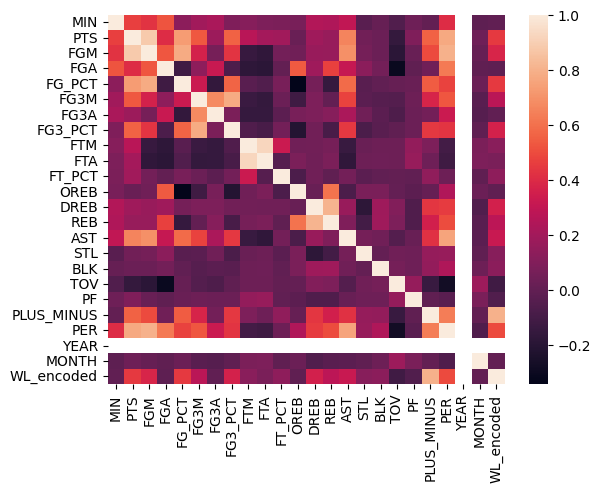

In [34]:
# Data Visualization to understand the variables better
# Heat Map

sns.heatmap(season_data.corr()) #coor for coordinates


In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Define the columns for the dependent (y) and independent (X) variables
X_columns = ['PLUS_MINUS', 'PER']  # Update the column names here
y_column = 'WL_encoded'

# Update season_data with encoded features
labelencoder = LabelEncoder()
season_data['TEAM_NAME'] = labelencoder.fit_transform(season_data['TEAM_NAME'])
season_data['MATCHUP'] = labelencoder.fit_transform(season_data['MATCHUP'])

categorical_columns = ['TEAM_NAME', 'MATCHUP', 'YEAR', 'MONTH']
onehotencoder = OneHotEncoder()
X_encoded = onehotencoder.fit_transform(season_data[categorical_columns]).toarray()

X_encoded_df = pd.DataFrame(X_encoded, columns=onehotencoder.get_feature_names_out(categorical_columns))
season_data_encoded = pd.concat([season_data.drop(categorical_columns, axis=1), season_data['TEAM_NAME'], X_encoded_df], axis=1)

# Define X and y using the updated season_data_encoded
X = season_data_encoded[X_columns]
y = season_data_encoded[y_column]

# Drop rows with missing values
X.dropna(inplace=True)
y = y[X.index]

# Reset the index of X and y to align with each other
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Confirm the shape of X and y after handling missing values
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)



Shape of X: (2659, 2)
Shape of y: (2659,)


C:\Users\ghadf\AppData\Local\Temp\ipykernel_3940\2795015454.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


In [95]:


# Perform one-hot encoding on categorical variables
#categorical_columns = [ 'TEAM_ABBREVIATION', 'TEAM_NAME', 'MATCHUP', 'PER', 'YEAR', 'MONTH']
#encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
#X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))

# Combine encoded features with the remaining numeric columns
#X_encoded.columns = encoder.get_feature_names_out(categorical_columns)
#X = pd.concat([X.drop(categorical_columns, axis=1), X_encoded], axis=1)


# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test)

# Create an SVM model and fit it to the training data
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Use the trained SVM model to predict the NBA championship winner based on the test data
y_pred_svm = svm_model.predict(X_test)

# Create a random forest model and fit it to the training data
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Use the trained random forest model to predict the NBA championship winner based on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the accuracy of the model using mean squared error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"LR Mean squared error: {mse_lr:.2f}")
print(f"LR R-squared: {r2_lr:.2f}")

# Evaluate the accuracy of the SVM model using mean squared error and R-squared
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)

print(f"SVM Mean squared error: {mse_svm:.2f}")
print(f"SVM R-squared: {r2_svm:.2f}")

# Evaluate the accuracy of the random forest model using mean squared error and R-squared
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Mean squared error: {mse_rf:.2f}")
print(f"Random Forest R-squared: {r2_rf:.2f}")

# Reset the index of y_test to align with the indices of season_data_encoded
y_test.reset_index(drop=True, inplace=True)

# Get the team names from the original dataset
#team_names = season_data.loc[X_test.index, 'TEAM_NAME'].reset_index(drop=True)
#team_names = season_data.loc[X_test.index.values, 'TEAM_NAME'].reset_index(drop=True)
team_names = season_data.reset_index().loc[X_test.index, 'TEAM_NAME'].reset_index(drop=True)

# Create a DataFrame with team names and predicted probabilities for linear regression
probabilities_df_lr = pd.DataFrame({'Team': team_names, 'Probability': y_pred_lr})

# Sort the DataFrame by probabilities in descending order for linear regression
probabilities_df_lr = probabilities_df_lr.sort_values('Probability', ascending=False)

# Print the table of teams with their probabilities for linear regression
print(probabilities_df_lr)

# Create a DataFrame with team names and predicted probabilities for random forest
probabilities_df_rf = pd.DataFrame({'Team': team_names, 'Probability': y_pred_rf})

# Sort the DataFrame by probabilities in descending order for random forest
probabilities_df_rf = probabilities_df_rf.sort_values('Probability', ascending=False)

# Print the table of teams with their probabilities for random forest
print(probabilities_df_rf)



LR Mean squared error: 0.09
LR R-squared: 0.62
SVM Mean squared error: 0.00
SVM R-squared: 1.00
Random Forest Mean squared error: 0.00
Random Forest R-squared: 1.00
     Team  Probability
488    23     2.044657
467    19     1.841844
193    26     1.726440
163     2     1.705587
341     5     1.688542
..    ...          ...
420    12    -0.608876
335    13    -0.671148
527     3    -0.679527
172    28    -0.701903
187    25    -0.748654

[532 rows x 2 columns]
     Team  Probability
266    20          1.0
179    15          1.0
312    13          1.0
310    21          1.0
309    25          1.0
..    ...          ...
308     1          0.0
306    16          0.0
305    10          0.0
116    20          0.0
0      27          0.0

[532 rows x 2 columns]


In [ ]:
#Predict Template
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate the accuracy of the model using mean squared error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"LR Mean squared error: {mse_lr:.2f}")
print(f"LR R-squared: {r2_lr:.2f}")

In [98]:
# **Behind the scenes LR:
# Calculating the Coefficients
print('coeffs = ',lr_model.coef_)

# Calc the Intercepts
print('intercepts = ',lr_model.intercept_)

coeff =  [ 0.02923187 -0.0007617 ]
intercepts =  0.5936270534038065


In [100]:
# Calc the R_sq_score
from sklearn.metrics import r2_score
r2_lr2 = r2_score(y_test, y_pred_lr)

print("r2 = ",r2_lr2)

r2 =  0.6218899103524678
